In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import contextily as cx  
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import cKDTree
from datetime import datetime
from matplotlib import gridspec
import scipy.stats as stats
import wavespectra
import netCDF4 as nc
import h5py
import scipy.io
from datetime import datetime,timedelta
#import 
%matplotlib inline


In [2]:
# Read all datasets into a dictionary for easy access
example_data = {}

def read_matlab_data_example(filepath):
    data = {}
    with h5py.File(filepath, 'r') as f:
        for key in f.keys():
            data[key] = f[key][()]
    return data

def read_matlab_data(filepath):
    """
    Read a MATLAB .mat file using scipy.io.loadmat and return a dictionary.
    """
    data = scipy.io.loadmat(filepath)
    # Remove MATLAB metadata entries
    data = {k: v for k, v in data.items() if not k.startswith('__')}
    return data

example_data = read_matlab_data_example('/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/spectral_buoy_data/example_spectra.mat')


In [3]:
print(example_data['lat'])
example_lat_WGS84 = example_data['lat'] - 90 if example_data['lat'] > 90 else example_data['lat']
print(example_lat_WGS84)

[[27.]]
[[27.]]


In [4]:
print(example_data['lon'])
# Convert example_lon from 0-360 to -180 to 180
example_lon_WGS84 = (example_data['lon'] + 180) % 360 - 180
print(example_lon_WGS84)

[[240.135]]
[[-119.865]]


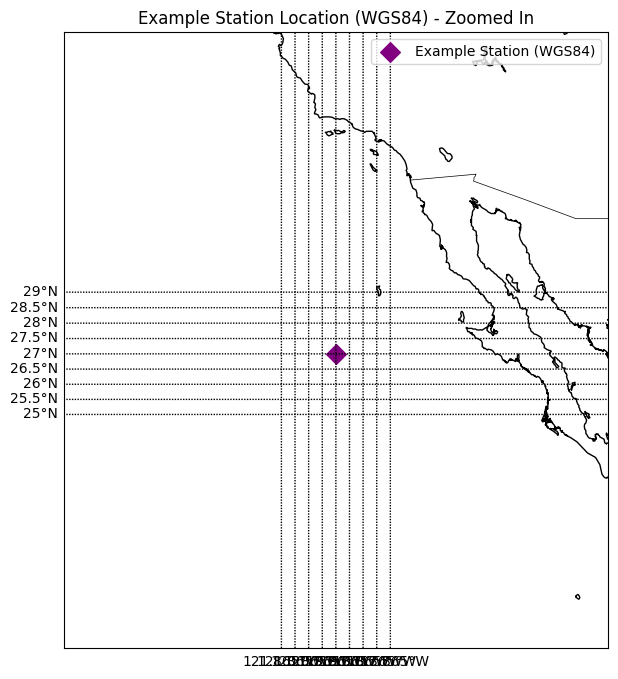

In [5]:
lat0 = example_lat_WGS84.item()
lon0 = example_lon_WGS84.item()

plt.figure(figsize=(8, 8))
m = Basemap(
    projection='merc',
    llcrnrlon=lon0 - 10,
    llcrnrlat=lat0 - 10,
    urcrnrlon=lon0 + 10,
    urcrnrlat=lat0 + 10,
    resolution='i'
)
m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(lat0 - 2, lat0 + 2.1, 0.5), labels=[1,0,0,0])
m.drawmeridians(np.arange(lon0 - 2, lon0 + 2.1, 0.5), labels=[0,0,0,1])

x_example_wgs84, y_example_wgs84 = m(lon0, lat0)
m.scatter(x_example_wgs84, y_example_wgs84, marker='D', color='purple', s=100, label='Example Station (WGS84)')

plt.legend()
plt.title('Example Station Location (WGS84) - Zoomed In')
plt.show()

In [6]:
def control_data(data):
    for key in data.keys():
        print(f"{key}: {data[key].shape} - {data[key].dtype} - first value = {data[key].flat[0]} - last value = {data[key].flat[-1]}")

control_data(example_data)




DIR: (24, 1) - float64 - first value = 7.5 - last value = 352.5
FRE: (30, 1) - float64 - first value = 0.034523 - last value = 0.547637
SPEC: (160704, 30, 24) - float64 - first value = nan - last value = nan
WTIME: (1, 160704) - float64 - first value = 719164.0 - last value = 739251.875
ans: (1, 1) - float64 - first value = 119.86500000000001 - last value = 119.86500000000001
lat: (1, 1) - float64 - first value = 27.0 - last value = 27.0
lon: (1, 1) - float64 - first value = 240.135 - last value = 240.135
u10: (1, 160704) - float64 - first value = -3.843440258297262 - last value = 0.47468355428485687
v10: (1, 160704) - float64 - first value = -4.039010228610598 - last value = 0.02619129001642584


In [7]:
# base_path = '/home/dvdhoorn/hurrywave_runs'
base_path = '/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/04_modelruns/YearSims'
path_ERA5 = '/gpfs/work3/0/ai4nbs/ERA5_data/data'

year_start = 2009
year_end = 2015
# model_name = '2013'
model_names = [str(year) for year in range(year_start, year_end + 1)]
model_paths = [os.path.join(base_path, model_name) for model_name in model_names]

# nc_file = os.path.join(model_path,'hurrywave_sp2.nc')
# inp_file = os.path.join(model_path,'hurrywave.inp')

# if os.path.exists(os.path.join(model_path, 'hurrywave.log')):
#     log_file = os.path.join(model_path, 'hurrywave.log')
# else:
#     log_file = None
#     print('WARNING: Log file not found at:', log_file)

postprocess_path = os.path.join(base_path, '2009to2015')
output_path = '/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/spectral_buoy_data'
filepath_data = '/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/spectral_buoy_data'

# Convert longitudes from -180..180 to 0..360
EPL_lon_old = 3.275037
EPL_lon = (3.275037 + 180) % 360
EPL_lat = 51.997799 # Euro platform
Hoorn_lon_old = 4.150286
Hoorn_lon = (4.150286 + 180) % 360
Hoorn_lat = 52.925353 # Platform Hoorn Q1-A
A12_lon_old = 3.817000
A12_lon = (3.817000 + 180) % 360
A12_lat = 55.417000 # A12 platform


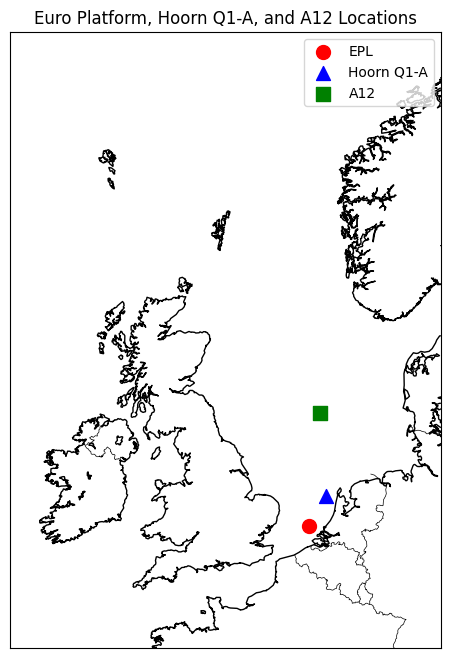

In [10]:
plt.figure(figsize=(8, 8))
m = Basemap(
    projection='merc',
    llcrnrlon=-12,
    llcrnrlat=48,
    urcrnrlon=10,
    urcrnrlat=65,
    resolution='i'
)
m.drawcoastlines()
m.drawcountries()
# m.drawparallels(np.arange(51, 57, 1), labels=[1,0,0,0])
# m.drawmeridians(np.arange(3, 6, 1), labels=[0,0,0,1])

# Plot the platforms
x_epl, y_epl = m(EPL_lon_old, EPL_lat)
x_hoorn, y_hoorn = m(Hoorn_lon_old, Hoorn_lat)
x_a12, y_a12 = m(A12_lon_old, A12_lat)

m.scatter(x_epl, y_epl, marker='o', color='red', s=100, label='EPL')
m.scatter(x_hoorn, y_hoorn, marker='^', color='blue', s=100, label='Hoorn Q1-A')
m.scatter(x_a12, y_a12, marker='s', color='green', s=100, label='A12')

plt.legend()
plt.title('Euro Platform, Hoorn Q1-A, and A12 Locations')
plt.show()

In [ ]:
def extract_hourly_u10_v10(path_ERA5, years, lat, lon):
    """
    Extract hourly u10 and v10 at a specific lat/lon for given years.
    Returns:
        times: concatenated array of datetime64
        u10: concatenated array of u10 values
        v10: concatenated array of v10 values
    """
    u10_all = []
    v10_all = []
    time_all = []
    for year in years:
        print(f'Extracting data for year: {year}')
        u10_file = os.path.join(path_ERA5, '10m_u_component_of_wind', f'global_10m_u_component_of_wind_{year}.nc')
        v10_file = os.path.join(path_ERA5, '10m_v_component_of_wind', f'global_10m_v_component_of_wind_{year}.nc')
        ds_u10 = xr.open_dataset(u10_file)
        ds_v10 = xr.open_dataset(v10_file)
        # Find nearest grid point
        abs_lat = np.abs(ds_u10['latitude'].values - lat)
        abs_lon = np.abs(ds_u10['longitude'].values - lon)
        i_lat = abs_lat.argmin()
        i_lon = abs_lon.argmin()
        # Extract time series at nearest grid point
        u10 = ds_u10['u10'][:, i_lat, i_lon].values
        v10 = ds_v10['v10'][:, i_lat, i_lon].values
        times = ds_u10['valid_time'].values
        u10_all.append(u10)
        v10_all.append(v10)
        time_all.append(times)
        ds_u10.close()
        ds_v10.close()
    u10_all = np.concatenate(u10_all)
    v10_all = np.concatenate(v10_all)
    time_all = np.concatenate(time_all)
    # Convert all times to numpy.datetime64[ns]
    time_all = time_all.astype('datetime64[ns]')
    return time_all, u10_all, v10_all

# Example usage:
# times, u10, v10 = extract_hourly_u10_v10(path_ERA5, [2010,2011], EPL_lat, EPL_lon)

A12_time_uv, A12_u10, A12_v10 = extract_hourly_u10_v10(path_ERA5, [2009, 2010, 2011, 2012, 2013], A12_lat, A12_lon_old)
Hoorn_time_uv, Hoorn_u10, Hoorn_v10 = extract_hourly_u10_v10(path_ERA5, [2009, 2010, 2011, 2012, 2013], Hoorn_lat, Hoorn_lon_old)
EPL_time_uv, EPL_u10, EPL_v10 = extract_hourly_u10_v10(path_ERA5, [2010, 2011, 2012, 2013, 2014, 2015], EPL_lat, EPL_lon_old)

Extracting data for year: 2009
Extracting data for year: 2010
Extracting data for year: 2011
Extracting data for year: 2012
Extracting data for year: 2013
Extracting data for year: 2009
Extracting data for year: 2010
Extracting data for year: 2011
Extracting data for year: 2012
Extracting data for year: 2013
Extracting data for year: 2010
Extracting data for year: 2011
Extracting data for year: 2012
Extracting data for year: 2013
Extracting data for year: 2014
Extracting data for year: 2015


In [10]:
def get_dt(inp_file, log_file):
    dt = None
    if log_file and os.path.exists(log_file):
        with open(log_file, 'r') as f:
            for line in f:
                if 'Warning! Reducing dt from' in line:
                    parts = line.strip().split('to')
                    if len(parts) == 2:
                        try:
                            dt = float(parts[1].split()[0])
                            print('taking dt from log file')
                            print(f'dt found in log file: {dt} s')
                            return dt
                        except Exception:
                            pass
    # If not found in log file, read from input file
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('dt'):
                parts = line.split('=')
                if len(parts) == 2:
                    try:
                        dt = float(parts[1].split(',')[0].strip())
                        print('taking dt from input file')
                        print(f'dt found in input file: {dt} s')
                        return dt
                    except Exception:
                        pass
    raise ValueError("dt could not be found in log or input file")

def get_spectra_output_dt(inp_file):
    dtsp2out = None
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('dtsp2out'):
                parts = line.split('=')
                if len(parts) == 2:
                    try:
                        dtsp2out = float(parts[1].split(',')[0].strip())
                        print(f'spectra output dt found in input file: {dtsp2out} s')
                        return dtsp2out
                    except Exception:
                        pass
    print("WARNING: dtsp2out not found in input file")
    return None

def get_timesteps(inp_file, log_file):
    # Read tstart and tend from inp_file
    tstart = None
    tend = None
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('tstart'):
                tstart_str = line.split('=')[1].strip().split(',')[0]
                tstart = datetime.strptime(tstart_str, "%Y%m%d %H%M%S")
            if line.strip().startswith('tstop'):
                tstop_str = line.split('=')[1].strip().split(',')[0]
                tstop = datetime.strptime(tstop_str, "%Y%m%d %H%M%S")
    if tstart is None or tstop is None:
        raise ValueError("tstart or tend not found in inp file")

    dt = get_spectra_output_dt(inp_file)
    nsteps = int((tstop - tstart).total_seconds() // dt) + 1

    # Remove the spinup times
    t_spinup = None
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('tspinup'):
                t_spinup_str = line.split('=')[1].strip().split(',')[0]
                t_spinup = float(t_spinup_str)
                break
    if t_spinup is None:
        raise ValueError("tspinup not found in input file")
    

    time_steps = np.array([tstart + timedelta(seconds=i*dt) for i in range(nsteps)])

    # Remove the spinup times
    # Remove all time steps before tstart + tspinup seconds
    spinup_end_time = tstart + timedelta(seconds=t_spinup)
    time_steps = time_steps[time_steps >= spinup_end_time]

    return time_steps

for model_name in model_names:
    model_path = os.path.join(base_path, model_name)
    inp_file = os.path.join(model_path, 'hurrywave.inp')
    log_file = os.path.join(model_path, 'hurrywave.log') if os.path.exists(os.path.join(model_path, 'hurrywave.log')) else None

    this_model_timesteps = get_timesteps(inp_file, log_file)
    model_timesteps = np.concatenate((model_timesteps, this_model_timesteps)) if 'model_timesteps' in locals() else this_model_timesteps # concatenate all timesteps

    print("First timestep:", model_timesteps[0])
    print("Last timestep:", model_timesteps[-1])

spectra output dt found in input file: 3600.0 s
First timestep: 2009-01-01 00:00:00
Last timestep: 2009-12-31 23:00:00
spectra output dt found in input file: 3600.0 s
First timestep: 2009-01-01 00:00:00
Last timestep: 2010-12-31 23:00:00
spectra output dt found in input file: 3600.0 s
First timestep: 2009-01-01 00:00:00
Last timestep: 2011-12-31 23:00:00
spectra output dt found in input file: 3600.0 s
First timestep: 2009-01-01 00:00:00
Last timestep: 2012-12-31 23:00:00
spectra output dt found in input file: 3600.0 s
First timestep: 2009-01-01 00:00:00
Last timestep: 2013-12-31 23:00:00
spectra output dt found in input file: 3600.0 s
First timestep: 2009-01-01 00:00:00
Last timestep: 2014-12-31 23:00:00
spectra output dt found in input file: 3600.0 s
First timestep: 2009-01-01 00:00:00
Last timestep: 2015-12-31 23:00:00


In [11]:
def ds_remove_spinup(year, model_base_path, ds):
    # Find the start and stop times from the input file
    inp_file = os.path.join(model_base_path, str(year), 'hurrywave.inp')
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('tspinup'):
                tspinup = line.split('=')[1].strip()

    tspinup_sec = int(tspinup)
    ds_time_vals = ds["time"].values
    spinup_end_time = ds_time_vals[0] + np.timedelta64(tspinup_sec, 's')
    ds_spinup_mask = ds_time_vals >= spinup_end_time
    ds = ds.sel(time=ds_spinup_mask)
    return ds

In [12]:
def process_station_data(model_base_path, outdir, y0, y1, save=True):
    print('Starting Hurrywave station extraction...')

    years = np.arange(y0, y1 + 1)
    data_per_station = {}
    sigma = None
    theta = None

    for y in years:
        print(f'Processing year: {y}')
        fname = os.path.join(model_base_path, str(y), 'hurrywave_sp2.nc')
        ds = xr.open_dataset(fname)
        ds = ds_remove_spinup(y, model_base_path, ds)


        nstations = ds.dims['stations']
        station_names = ds['station_name'].astype(str).values
        if sigma is None:
            sigma = ds['sigma'].values
        if theta is None:
            theta = ds['theta'].values
            theta = (270 - theta) % 360 # Convert to meteorological convention

        time = ds['time'].values
        data_vars = ['point_spectrum2d']

        for i in range(nstations):
            station = station_names[i].strip()
            print(f'  - Extracting {station}')

            if station not in data_per_station:
                data_per_station[station] = {var: [] for var in data_vars}
                data_per_station[station]['time'] = []

            for var in data_vars:
                data_per_station[station][var].append(ds[var].isel(stations=i).values)
            data_per_station[station]['time'].append(time)

        ds.close()

    for station in data_per_station:
        for key in data_per_station[station]:
            data_per_station[station][key] = np.concatenate(data_per_station[station][key])

    if save:
        print('All years loaded. Starting export...')
        os.makedirs(outdir, exist_ok=True)

        for station, data in data_per_station.items():
            outpath = os.path.join(outdir, f'{station}.npz')
            np.savez(os.path.join(outdir, 'global_coords.npz'), sigma=sigma, theta=theta)
            np.savez(outpath, **data)
            print(f'  ✓ Saved {station}.npz with {len(data["time"])} timesteps.')

        print(f'Extraction finished. Data saved to: {outdir}')
    else:
        print(f'Extraction complete. Data not saved (save=False).')

    return data_per_station, sigma, theta

In [13]:
# === Run station extraction ===
np.set_printoptions(threshold=np.inf)
ds, sigma, theta = process_station_data(
    model_base_path=base_path,
    outdir=postprocess_path,
    y0=year_start,
    y1=year_end,
    save=False
)

# === Build one big 4D array: (time, site, dir, freq) ===
site_names = list(ds.keys())
n_sites = len(site_names)
n_freq = len(sigma)
n_dir = len(theta)

# Get time length from first station
time_lens = [len(ds[site]["time"]) for site in site_names]
if not all(t == time_lens[0] for t in time_lens):
    raise ValueError("Mismatch in time lengths across stations, cannot stack directly.")

nt = time_lens[0]

Starting Hurrywave station extraction...
Processing year: 2009


/scratch-local/72649/ipykernel_174953/1864478586.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Processing year: 2010


/scratch-local/72649/ipykernel_174953/1864478586.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Processing year: 2011


/scratch-local/72649/ipykernel_174953/1864478586.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Processing year: 2012


/scratch-local/72649/ipykernel_174953/1864478586.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Processing year: 2013


/scratch-local/72649/ipykernel_174953/1864478586.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Processing year: 2014


/scratch-local/72649/ipykernel_174953/1864478586.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Processing year: 2015


/scratch-local/72649/ipykernel_174953/1864478586.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Extraction complete. Data not saved (save=False).


In [14]:
# Load data
# Initialize big efth array
efth_all = np.zeros((nt, n_sites, n_dir, n_freq))
for i, site in enumerate(site_names):
    efth_all[:, i, :, :] = ds[site]["point_spectrum2d"]

# Apply scaling and remove last timestep if needed

efth_all = efth_all * 10 / (180 / np.pi)
efth_all = efth_all[:-1]
model_timesteps = ds[site_names[0]]["time"][:-1]  # use one station's time
site_coord = np.array(site_names)

# === Final DataArray ===
model_da = xr.DataArray(
    data=efth_all,
    dims=["time", "site", "dir", "freq"],
    coords=dict(
        time=model_timesteps,
        site=site_coord,
        dir=theta,
        freq=sigma,
    ),
    name="efth",
)
model_dset = model_da.to_dataset()

# Remove duplicate times for each station in model_dset
for site in site_names:
    da = model_dset.efth.sel(site=site)
    time_vals = da.coords["time"].values
    _, unique_indices = np.unique(time_vals, return_index=True)
    # Sort indices to preserve order
    unique_indices = np.sort(unique_indices)
    # Select only unique times and corresponding values
    unique_times = time_vals[unique_indices]
    # Create a new DataArray with unique times for this site
    da_unique = da.isel(time=unique_indices)
    if site == site_names[0]:
        # Initialize new arrays for all sites
        efth_unique = np.empty((len(unique_times), len(site_names), n_dir, n_freq), dtype=da.dtype)
        efth_unique[:] = np.nan
        time_unique = unique_times
    efth_unique[:, site_names.index(site), :, :] = da_unique.values

# Build new DataArray and Dataset with unique times (assumes all sites have same unique times)
model_da_unique = xr.DataArray(
    data=efth_unique,
    dims=["time", "site", "dir", "freq"],
    coords=dict(
        time=time_unique,
        site=site_coord,
        dir=theta,
        freq=sigma,
    ),
    name="efth",
)
model_dset = model_da_unique.to_dataset()

# After this, all time coordinates for each station are unique and values are aligned

# Select A12 (station008) and Hoorn (station003) from 2009 to 2013
A12_model_dset = model_dset.efth.sel(
    site="station_008",
    time=slice("2009-01-01", "2013-12-31")
)
Hoorn_model_dset = model_dset.efth.sel(
    site="station_003",
    time=slice("2009-01-01", "2013-12-31")
)

# Select EPL (station001) from 2010 to 2015
EPL_model_dset = model_dset.efth.sel(
    site="station_001",
    time=slice("2010-01-01", "2015-12-31")
)



In [15]:
print(EPL_model_dset.coords["time"].shape)
print(EPL_time_uv.shape)

# Find times in EPL_time_uv that are not in EPL_model_dset.coords["time"]
missing_times_epl = np.setdiff1d(EPL_time_uv, EPL_model_dset.coords["time"].values)
print(f"Number of missing times: {len(missing_times_epl)}")
print("First 10 missing times:", missing_times_epl[:10])

# Check for duplicate times in EPL_model_dset time coordinate
epl_model_times = EPL_model_dset.coords["time"].values
unique_times_epl, counts_epl = np.unique(epl_model_times, return_counts=True)
duplicates_epl = unique_times_epl[counts_epl > 1]
print(f"Number of duplicate times: {len(duplicates_epl)}")
if len(duplicates_epl) > 0:
    print("Duplicate times:", duplicates_epl)
else:
    print("No duplicate times found.")



(52584,)
(52584,)
Number of missing times: 0
First 10 missing times: []
Number of duplicate times: 0
No duplicate times found.


In [ ]:
def read_spectra(filepath,data_name):
    # Load .mat files
    Czz = scipy.io.loadmat(os.path.join(filepath, f'{data_name}_Czz.mat'))['Czz'].flatten()
    Th0 = scipy.io.loadmat(os.path.join(filepath, f'{data_name}_Th0.mat'))['Th0'].flatten()

    yds = datetime(2009, 2, 1, 12, 10, 0)  # A12

    vpm_Czz = 101
    vpm_Th0 = 96
    nCzz = len(Czz)
    nTh0 = len(Th0)
    nsp = nCzz // vpm_Czz

    # reconstruct time vector
    tt = np.array([yds + timedelta(minutes=10*i) for i in range(nsp)])

    # frequency and direction bins
    fw = np.concatenate(([0, 0.005], np.arange(0.015, 1.0, 0.01)))
    fd = np.concatenate(([0.03], np.arange(0.035, 0.5, 0.01)))
    nfd = len(fd)

    # time window
    ydi1, moi1, ddi1 = 2009, 2, 1
    ydi2, moi2, ddi2 = 2013, 12, 31
    ydr1 = datetime(ydi1, moi1, ddi1)
    ydr2 = datetime(ydi2, moi2, ddi2)

    ii = np.where((tt >= ydr1) & (tt <= ydr2))[0]
    ng = len(ii)
    jg = 0

    df = 0.01
    ff = np.arange(0.035, 0.485 + df, df)
    nf = len(ff)
    dtheta = 10 * np.pi / 180
    theta_r = np.arange(-np.pi, np.pi + dtheta, dtheta)
    ntheta = len(theta_r)

    Efdt = []
    Efdt_per_degree = []
    Hm0 = []
    thetap = []
    Tp = []

    for jsp in range(ii[0], ii[-1] + 1):
        jg += 1
        E = Czz[(jsp)*vpm_Czz:(jsp+1)*vpm_Czz]
        thetam = Th0[(jsp)*vpm_Th0:(jsp)*vpm_Th0+nfd]
        thetas = Th0[(jsp)*vpm_Th0+nfd:(jsp)*vpm_Th0+2*nfd]

        Ef = E[4:51]  # 5:51 in MATLAB is 4:51 in Python (0-based)
        tf = thetam[1:-1]
        sf = thetas[1:-1]

        s = np.maximum(np.round(2. / (sf * np.pi / 180) ** 2 - 1), 1)
        m = 2 * s

        Efd = np.zeros((ntheta, nf))
        for jf in range(nf):
            Dd = np.maximum(np.cos(0.5 * (theta_r - tf[jf] * np.pi / 180)) ** (m[jf]), np.finfo(float).eps)
            Ad = 1. / (np.sum(Dd) * dtheta) 
            Dd = Dd * Ad
            Efd[:, jf] = Ef[jf] * Dd

        Efd = Efd / 1e4  # to get to m2/Hz
        
        Efdt.append(Efd)
        Eff = np.sum(Efd, axis=0) * dtheta
        Ett = np.sum(Efd, axis=1) * df
        ig = np.where(ff > 0.04)[0]
        Hm0.append(4 * np.sqrt(np.sum(Eff[ig]) * df))
        it = np.argmax(Ett)
        is_ = np.argmax(Eff)
        thetap.append(theta_r[it] * 180 / np.pi)
        Tp.append(1. / ff[is_])

        # Convert to m2/degree/Hz
        dtheta_deg = dtheta * 180 / np.pi  # Convert radians to degrees (10°)
        Efd_per_degree = Efd.copy() / ( 180 / np.pi)  # Correct for external use
        Efdt_per_degree.append(Efd_per_degree)

    theta_r = theta_r * 180 / np.pi  # Convert to degrees
    theta_r = theta_r + 180 # Shift to positive degrees
    theta_r = (theta_r + 180) % 360 # Make sure the waves come from the right direction
    ttw = tt[ii]
    return {
        'ttw': ttw,
        'Hm0': np.array(Hm0),
        'thetap': np.array(thetap),
        'Tp': np.array(Tp),
        'theta_r': theta_r,
        'ff': ff,
        'Efdt': np.array(Efdt),
        'Efdt_per_degree': np.array(Efdt_per_degree)
    }
    
A12_spectra_data = read_spectra(filepath_data,'A12')
Hoorn_spectra_data = read_spectra(filepath_data,'H')

print(f"Units: data_Efdt is in m²/Hz, data_Efdt_per_degree is in m²/degree/Hz")


# # Create DataArray, with an added dimension (as in your original line)
A12_data_da = xr.DataArray(
    data=A12_spectra_data['Efdt_per_degree'],

    dims=["time","dir", "freq"],
    coords=dict(time=A12_spectra_data['ttw'],freq=A12_spectra_data['ff'], dir=A12_spectra_data['theta_r']),
    name="efth",
)

Hoorn_data_da = xr.DataArray(
    data=Hoorn_spectra_data['Efdt_per_degree'],

    dims=["time","dir", "freq"],
    coords=dict(time=Hoorn_spectra_data['ttw'],freq=Hoorn_spectra_data['ff'], dir=Hoorn_spectra_data['theta_r']),
    name="efth",
)

A12_data_dset = A12_data_da.to_dataset()
Hoorn_data_dset = Hoorn_data_da.to_dataset()

In [ ]:
def read_epl_spectra(filepath, ipart=1, xaver=1, egon=0, jy=3):
    """
    Reconstruct frequency-directional spectra for Euro Platform (EPL) observations.
    
    Parameters:
        filepath: folder where .mat files are stored
        ipart: 1 for first part, 2 for second part
        xaver: 1 if only for storm XAVER
        egon: 1 if only for storm EGON
        jy: year offset for the analysis (3 for XAVER)
        
    Returns:
        Dictionary with time series, wave parameters, and spectra
    """
    # Load appropriate part
    if ipart == 1:
        Czz = scipy.io.loadmat(os.path.join(filepath, 'H_Czz_EPL3_p1.mat'))['Czz10'].flatten()
        Th0 = scipy.io.loadmat(os.path.join(filepath, 'H_Th0_EPL3_p1.mat'))['Th010'].flatten()
        Sh0 = scipy.io.loadmat(os.path.join(filepath, 'H_Sh0_EPL3_p1.mat'))['Sh010'].flatten()
        yds = datetime(2010, 1, 1, 0, 0, 0)
    else:
        Czz = scipy.io.loadmat(os.path.join(filepath, 'H_Czz_EPL3_p2.mat'))['Czz10'].flatten()
        Th0 = scipy.io.loadmat(os.path.join(filepath, 'H_Th0_EPL3_p2.mat'))['Th010'].flatten()
        Sh0 = scipy.io.loadmat(os.path.join(filepath, 'H_Sh0_EPL3_p2.mat'))['Sh010'].flatten()
        yds = datetime(2016, 8, 5, 0, 0, 0)

    # Parameters
    vpm_Czz = 51
    vpm_Th0 = 51
    vpm_Sh0 = 51
    nCzz = len(Czz)
    nTh0 = len(Th0)
    nSh0 = len(Sh0)
    nsp = nCzz // vpm_Czz

    # Time vector (10-minute intervals)
    tt = np.array([yds + timedelta(minutes=10*i) for i in range(nsp)])

    # Frequency and directional bins
    fw = np.arange(0, 0.51, 0.01)
    fd = np.arange(0, 0.51, 0.01)
    nfd = len(fd)

    # Define start and end datetime
    ydi1, moi1, ddi1 = 2010 + jy, 1, 1
    if xaver == 1:
        moi1 = 12
    if egon == 1:
        moi1, ddi1 = 1, 11
    ydr1 = datetime(ydi1, moi1, ddi1, 0, 0, 0)

    ydi2 = 2010 + jy
    if jy == 6 and ipart == 1:
        moi2, ddi2 = 8, 5
        ydr2 = datetime(ydi2, moi2, ddi2, 23, 40, 0)
    else:
        moi2, ddi2 = 12, 31
        if xaver == 1:
            ddi2 = 10
        if egon == 1:
            moi2, ddi2 = 1, 15
        ydr2 = datetime(ydi2, moi2, ddi2, 0, 0, 0) + timedelta(days=1)

    # Hourly averaging
    Dhr = 1
    nhr = Dhr * 6  # number of 10-min intervals per hour
    ii = np.where((tt > ydr1) & (tt < ydr2))[0]
    ng = round(len(ii) / nhr)

    # Preallocate arrays
    Hm0 = []
    Tp = []
    Dspr_mean = []
    theta_mean = []
    fm_01 = []
    fm_10 = []
    fm_20 = []
    tth = []
    Efdt = []
    Efdt_per_degree = []

    df = 0.01
    ff = fw[4:51]  # MATLAB 5:51 -> Python 4:51
    nf = len(ff)
    dtheta = 10 * np.pi / 180
    theta_r = np.arange(-np.pi, np.pi + dtheta, dtheta)
    ntheta = len(theta_r)

    for jg, jsp in enumerate(range(ii[0], ii[-1], nhr)):
        E = np.zeros(vpm_Czz)
        thetamx = np.zeros(nfd)
        thetamy = np.zeros(nfd)
        thetas = np.zeros(nfd)

        for jhr in range(nhr):
            idx_Czz = slice((jsp + jhr) * vpm_Czz, (jsp + jhr + 1) * vpm_Czz)
            Htot = 4 * np.sqrt(np.sum(Czz[idx_Czz]) / 1e4 * 0.01)
            if Htot > 9:
                E[:] = np.nan
            else:
                E += Czz[idx_Czz]

            idx_Th0 = slice((jsp + jhr) * vpm_Th0, (jsp + jhr) * vpm_Th0 + nfd)
            thetamx += np.cos(np.deg2rad(Th0[idx_Th0]))
            thetamy += np.sin(np.deg2rad(Th0[idx_Th0]))

            idx_Sh0 = slice((jsp + jhr) * vpm_Sh0, (jsp + jhr) * vpm_Sh0 + nfd)
            thetas += Sh0[idx_Sh0]

        # Hourly mean
        E /= nhr
        thetamx /= nhr
        thetamy /= nhr
        thetas /= nhr
        thetam = np.rad2deg(np.arctan2(thetamy, thetamx))

        # Reconstruct directional spectrum
        Ef = E[4:51]
        tf = thetam[4:51]
        sf = thetas[4:51]

        s = np.maximum(np.round(2. / (sf * np.pi / 180)**2 - 1), 1)
        m = 2 * s

        Efd = np.zeros((ntheta, nf))
        for jf in range(nf):
            Dd = np.maximum(np.cos(0.5 * (theta_r - np.deg2rad(tf[jf]))) ** m[jf], np.finfo(float).eps)
            Ad = 1. / (np.sum(Dd) * dtheta)
            Dd *= Ad
            Efd[:, jf] = Ef[jf] * Dd

        Efd = Efd / 1e4  # m2/Hz
        Efdt.append(Efd)
        Efdt_per_degree.append(Efd / (180 / np.pi))  # per degree

        Eff = np.sum(Efd, axis=0) * dtheta
        Ett = np.sum(Efd, axis=1) * df
        ig = np.where(ff > 0.04)[0]
        Hm0.append(np.real(4 * np.sqrt(np.sum(Eff[ig]) * df)))
        it = np.argmax(Ett)
        is_ = np.argmax(Eff)
        theta_mean.append(tf.mean())
        Dspr_mean.append(sf.mean())
        Tp.append(1. / ff[is_])
        times_chunk = tt[jsp:jsp + nhr]
        timestamps = np.array([t.timestamp() for t in times_chunk])
        mean_time = datetime.fromtimestamp(np.mean(timestamps))
        # tth.append(mean_time)  # append once per hourly block
        # Instead of mean time:
        block_start = tt[jsp]
        # Or if you prefer the central hour mark:
        block_center = tt[jsp] - timedelta(minutes=10)

        tth.append(block_center)  # aligned to start of block

    # Convert theta_r to degrees, shift to 0-360
    theta_r = theta_r * 180 / np.pi  # Convert to degrees
    theta_r = theta_r + 180 # Shift to positive degrees
    theta_r = (theta_r + 180) % 360 # Make sure the waves come from the right direction

    ttw = tt[ii][::nhr]  # hourly timestamps

    return {
        'ttw': np.array(tth),
        'Hm0': np.array(Hm0),
        'thetap': np.array(theta_mean),
        'Tp': np.array(Tp),
        'theta_r': theta_r,
        'ff': ff,
        'Efdt': np.array(Efdt),
        'Efdt_per_degree': np.array(Efdt_per_degree)
    }

EPL_spectra_data_list = []
for jy in range(0, 6):
    EPL_spectra_data_list.append(read_epl_spectra(filepath_data, ipart=1, xaver=0, egon=0, jy=jy))
# Concatenate all years along the time dimension

# Concatenate each field across years
def concat_dicts(dicts, axis=0):
    out = {}
    for key in dicts[0]:
        if key in ["ff", "theta_r"]:  # static coords
            out[key] = dicts[0][key]
        elif isinstance(dicts[0][key], np.ndarray) and dicts[0][key].ndim > 0:
            out[key] = np.concatenate([d[key] for d in dicts], axis=axis)
        else:
            out[key] = np.array([d[key] for d in dicts])
    return out

EPL_spectra_data = concat_dicts(EPL_spectra_data_list)

EPL_data_da = xr.DataArray(
    data=EPL_spectra_data['Efdt_per_degree'],

    dims=["time","dir", "freq"],
    coords=dict(time=EPL_spectra_data['ttw'],freq=EPL_spectra_data['ff'], dir=EPL_spectra_data['theta_r']),
    name="efth",
)

EPL_data_dset = EPL_data_da.to_dataset()

/scratch-local/72649/ipykernel_138374/620615764.py:97: RuntimeWarning: invalid value encountered in sqrt
  Htot = 4 * np.sqrt(np.sum(Czz[idx_Czz]) / 1e4 * 0.01)
/scratch-local/72649/ipykernel_138374/620615764.py:139: RuntimeWarning: invalid value encountered in sqrt
  Hm0.append(np.real(4 * np.sqrt(np.sum(Eff[ig]) * df)))


In [ ]:
def thin_to_full_hours(dset, time_dim="time"):
    """
    Thin an xarray Dataset or DataArray to only include times at full hours.

    Parameters:
        dset: xarray.Dataset or xarray.DataArray
        time_dim: str, name of the time dimension (default: "time")

    Returns:
        Thinned xarray object with only full-hour time steps.
    """
    # Get the time coordinate as pandas.DatetimeIndex
    times = pd.to_datetime(dset[time_dim].values)

    # Build mask: keep only timestamps at full hours
    mask = (times.minute == 0) & (times.second == 0) & (times.microsecond == 0)

    # Select with boolean mask
    thinned = dset.isel({time_dim: mask})

    return thinned


# Usage
Hoorn_data_dset = thin_to_full_hours(Hoorn_data_dset)
A12_data_dset = thin_to_full_hours(A12_data_dset)

print(Hoorn_data_dset['time'].values[2])


2009-02-01T15:00:00.000000000


In [ ]:
def align_on_common_times(model_dset, data_dset, time_dim="time"):
    """
    Restrict a model xarray Dataset/DataArray to only the times
    that are also present in a data Dataset/DataArray.

    Parameters:
        model_dset : xarray.Dataset or xarray.DataArray
            The model dataset.
        data_dset : xarray.Dataset or xarray.DataArray
            The data dataset used as reference for times.
        time_dim : str, optional
            Name of the time dimension (default: "time").

    Returns:
        xarray.Dataset or xarray.DataArray
            A modified model dataset with only the common times.
    """
    # Extract time coordinates
    model_times = np.array(model_dset[time_dim].values)
    data_times = np.array(data_dset[time_dim].values)

    # Find intersection
    common_times = np.intersect1d(model_times, data_times)

    # Select model dataset only at common times
    model_aligned = model_dset.sel({time_dim: common_times})

    return model_aligned

EPL_model_dset = align_on_common_times(EPL_model_dset, EPL_data_dset, time_dim="time")
Hoorn_model_dset = align_on_common_times(Hoorn_model_dset, Hoorn_data_dset, time_dim="time")
A12_model_dset = align_on_common_times(A12_model_dset, A12_data_dset, time_dim="time")

In [ ]:
def align_uv_on_common_times(time_uv, u10, v10, data_times):
    """
    Thin time_uv, u10, and v10 arrays so they only include entries
    where time_uv matches data_times.

    Parameters:
        time_uv : np.ndarray
            Array of datetimes (same shape as u10, v10 time dimension).
        u10 : np.ndarray
            U-component of wind (aligned with time_uv).
        v10 : np.ndarray
            V-component of wind (aligned with time_uv).
        data_times : np.ndarray or list
            Reference times to keep (e.g., from observations).

    Returns:
        tuple of (time_uv_thinned, u10_thinned, v10_thinned)
    """
    # Ensure numpy datetime64
    time_uv = np.array(time_uv).astype("datetime64[ns]")
    data_times = np.array(data_times).astype("datetime64[ns]")

    # Find indices of common times
    common_times, keep_idx, _ = np.intersect1d(time_uv, data_times, return_indices=True)

    # Thin all arrays consistently
    time_thinned = time_uv[keep_idx]
    u10_thinned = u10[keep_idx]
    v10_thinned = v10[keep_idx]

    return time_thinned, u10_thinned, v10_thinned

EPL_time_uv, EPL_u10, EPL_v10 = align_uv_on_common_times(EPL_time_uv, EPL_u10, EPL_v10, EPL_data_dset.coords['time'].values)
Hoorn_time_uv, Hoorn_u10, Hoorn_v10 = align_uv_on_common_times(Hoorn_time_uv, Hoorn_u10, Hoorn_v10, Hoorn_data_dset.coords['time'].values)
A12_time_uv, A12_u10, A12_v10 = align_uv_on_common_times(A12_time_uv, A12_u10, A12_v10, A12_data_dset.coords['time'].values)

In [ ]:
print("EPL_model_dset.coords['time'] shape:", EPL_model_dset.coords['time'].shape)
print("EPL_data_dset shape:",  EPL_data_dset.coords['time'].shape)
print("EPL_time_uv shape:", EPL_time_uv.shape)
print("EPL_u10 shape:", EPL_u10.shape)
print("EPL_v10 shape:", EPL_v10.shape)

print("Hoorn_model_dset.coords['time'] shape:", Hoorn_model_dset.coords['time'].shape)
print("Hoorn_data_dset shape:", Hoorn_data_dset.coords['time'].shape)
print("Hoorn_time_uv shape:", Hoorn_time_uv.shape)
print("Hoorn_u10 shape:", Hoorn_u10.shape)
print("Hoorn_v10 shape:", Hoorn_v10.shape)

print("A12_model_dset.coords['time'] shape:", A12_model_dset.coords['time'].shape)
print("A12_data_dset shape:", A12_data_dset.coords['time'].shape)
print("A12_time_uv shape:", A12_time_uv.shape)
print("A12_u10 shape:", A12_u10.shape)
print("A12_v10 shape:", A12_v10.shape)

EPL_model_dset.coords['time'] shape: (52584,)
EPL_data_dset shape: (52584,)
EPL_time_uv shape: (52584,)
EPL_u10 shape: (52584,)
EPL_v10 shape: (52584,)
Hoorn_model_dset.coords['time'] shape: (43044,)
Hoorn_data_dset shape: (43044,)
Hoorn_time_uv shape: (43044,)
Hoorn_u10 shape: (43044,)
Hoorn_v10 shape: (43044,)
A12_model_dset.coords['time'] shape: (43044,)
A12_data_dset shape: (43044,)
A12_time_uv shape: (43044,)
A12_u10 shape: (43044,)
A12_v10 shape: (43044,)


In [25]:
print(A12_u10[20])
print(EPL_u10[20])

-5.6313934
-7.2161865


In [26]:
A12_model_freq = A12_model_dset.coords["freq"].values
A12_model_dir = A12_model_dset.coords["dir"].values
A12_model_spec = A12_model_dset.values
A12_model_time = A12_model_dset.coords["time"].values
# Convert numpy.datetime64 array to MATLAB datenum format
# MATLAB datenum = days since 0000-01-00, Python datetime64 is since 1970-01-01
# The offset between 0000-01-00 and 1970-01-01 is 719529 days

def datetime64_to_matlab_datenum(dates):
    """
    Convert numpy.datetime64 array to MATLAB datenum (days since year 0).
    """
    dates = np.asarray(dates, dtype='datetime64[s]')
    py_dates = dates.astype('O')  # convert to Python datetime
    matlab_datenum_1970 = 719529  # MATLAB datenum for 1970-01-01
    mdn = np.array([
        matlab_datenum_1970 + (d - datetime(1970, 1, 1)).total_seconds() / 86400
        for d in py_dates
    ], dtype=np.float64)
    return mdn

Hoorn_model_freq = Hoorn_model_dset.coords["freq"].values
Hoorn_model_dir = Hoorn_model_dset.coords["dir"].values
Hoorn_model_spec = Hoorn_model_dset.values
Hoorn_model_time = Hoorn_model_dset.coords["time"].values

EPL_model_freq = EPL_model_dset.coords["freq"].values
EPL_model_dir = EPL_model_dset.coords["dir"].values
EPL_model_spec = EPL_model_dset.values
EPL_model_time = EPL_model_dset.coords["time"].values

In [27]:
def export_matlab_spectra(filepath, name, station, DIR, FRE, SPEC, WTIME, lat, lon, u10, v10):
    """
    Export spectral data to a MATLAB .mat file using scipy.io.savemat.
    Note: scipy.io.savemat does not support HDF5-based v7.3 files, but saves in v7.2 format.
    """
    import scipy.io

    filename = os.path.join(filepath, f'{name}_spectral_data_{station}.mat')

    mat_dict = {
        'DIR': np.array(DIR, dtype=np.float64).reshape(-1, 1),
        'FRE': np.array(FRE, dtype=np.float64).reshape(-1, 1),
        'SPEC': np.array(SPEC, dtype=np.float64),
        'WTIME': datetime64_to_matlab_datenum(np.array(WTIME)).reshape(1, -1),
        'u10': np.array(u10, dtype=np.float64).reshape(1, -1),
        'v10': np.array(v10, dtype=np.float64).reshape(1, -1),
        'lat': np.array(lat, dtype=np.float64).reshape(1, 1),
        'lon': np.array(lon, dtype=np.float64).reshape(1, 1)
    }

    scipy.io.savemat(filename, mat_dict, do_compression=True)

export_matlab_spectra(
    filepath=filepath_data,
    name='model',
    station='EPL',
    DIR=EPL_model_dir,
    FRE=EPL_model_freq,
    SPEC=EPL_model_spec,
    WTIME=EPL_model_time,
    lat=EPL_lat,
    lon=EPL_lon,
    u10=EPL_u10,
    v10=EPL_v10
)

export_matlab_spectra(
    filepath=filepath_data,
    name='model',
    station='Hoorn',
    DIR=Hoorn_model_dir,
    FRE=Hoorn_model_freq,
    SPEC=Hoorn_model_spec,
    WTIME=Hoorn_model_time,
    lat=Hoorn_lat,
    lon=Hoorn_lon,
    u10=Hoorn_u10,
    v10=Hoorn_v10
)

export_matlab_spectra(
    filepath=filepath_data,
    name='model',
    station='A12',
    DIR=A12_model_dir,
    FRE=A12_model_freq,
    SPEC=A12_model_spec,
    WTIME=A12_model_time,
    lat=A12_lat,
    lon=A12_lon,
    u10=A12_u10,
    v10=A12_v10
)

export_matlab_spectra(
    filepath=filepath_data,
    name='buoy',
    station='EPL',
    DIR=EPL_data_dset.coords["dir"].values,
    FRE=EPL_data_dset.coords["freq"].values,
    SPEC=EPL_data_dset.efth.values,
    WTIME=EPL_data_dset.coords["time"].values,
    lat=EPL_lat,
    lon=EPL_lon,
    u10=EPL_u10,
    v10=EPL_v10
)

export_matlab_spectra(
    filepath=filepath_data,
    name='buoy',
    station='Hoorn',
    DIR=Hoorn_data_dset.coords["dir"].values,
    FRE=Hoorn_data_dset.coords["freq"].values,
    SPEC=Hoorn_data_dset.efth.values,
    WTIME=Hoorn_data_dset.coords["time"].values,
    lat=Hoorn_lat,
    lon=Hoorn_lon,
    u10=Hoorn_u10,
    v10=Hoorn_v10
)

export_matlab_spectra(
    filepath=filepath_data,
    name='buoy',
    station='A12',
    DIR=A12_data_dset.coords["dir"].values,
    FRE=A12_data_dset.coords["freq"].values,
    SPEC=A12_data_dset.efth.values,
    WTIME=A12_data_dset.coords["time"].values,
    lat=A12_lat,
    lon=A12_lon,
    u10=A12_u10,
    v10=A12_v10
)



In [28]:
# Read the .mat file
A12_model_mat_data = read_matlab_data('/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/spectral_buoy_data/model_spectral_data_A12.mat')
Hoorn_model_mat_data = read_matlab_data('/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/spectral_buoy_data/model_spectral_data_Hoorn.mat')
EPL_model_mat_data = read_matlab_data('/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/spectral_buoy_data/model_spectral_data_EPL.mat')

A12_buoy_mat_data = read_matlab_data('/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/spectral_buoy_data/buoy_spectral_data_A12.mat') 
Hoorn_buoy_mat_data = read_matlab_data('/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/spectral_buoy_data/buoy_spectral_data_Hoorn.mat')
EPL_buoy_mat_data = read_matlab_data('/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/spectral_buoy_data/buoy_spectral_data_EPL.mat')



In [29]:
control_data(example_data)

DIR: (24, 1) - float64 - first value = 7.5 - last value = 352.5
FRE: (30, 1) - float64 - first value = 0.034523 - last value = 0.547637
SPEC: (160704, 30, 24) - float64 - first value = nan - last value = nan
WTIME: (1, 160704) - float64 - first value = 719164.0 - last value = 739251.875
ans: (1, 1) - float64 - first value = 119.86500000000001 - last value = 119.86500000000001
lat: (1, 1) - float64 - first value = 27.0 - last value = 27.0
lon: (1, 1) - float64 - first value = 240.135 - last value = 240.135
u10: (1, 160704) - float64 - first value = -3.843440258297262 - last value = 0.47468355428485687
v10: (1, 160704) - float64 - first value = -4.039010228610598 - last value = 0.02619129001642584


In [30]:
control_data(A12_model_mat_data)

DIR: (36, 1) - float64 - first value = 265.0 - last value = 275.0000305175781
FRE: (12, 1) - float64 - first value = 0.03999999910593033 - last value = 0.49999985098838806
SPEC: (43044, 36, 12) - float64 - first value = 3.0242262935847222e-09 - last value = 0.00012267111609358194
WTIME: (1, 43044) - float64 - first value = 733805.5416666666 - last value = 735599.0
u10: (1, 43044) - float64 - first value = 4.5498504638671875 - last value = 5.4032135009765625
v10: (1, 43044) - float64 - first value = -4.5665740966796875 - last value = -1.340606689453125
lat: (1, 1) - float64 - first value = 55.417 - last value = 55.417
lon: (1, 1) - float64 - first value = 183.817 - last value = 183.817


In [31]:
control_data(Hoorn_model_mat_data)

DIR: (36, 1) - float64 - first value = 265.0 - last value = 275.0000305175781
FRE: (12, 1) - float64 - first value = 0.03999999910593033 - last value = 0.49999985098838806
SPEC: (43044, 36, 12) - float64 - first value = 3.79921052171314e-09 - last value = 8.721680880318258e-05
WTIME: (1, 43044) - float64 - first value = 733805.5416666666 - last value = 735599.0
u10: (1, 43044) - float64 - first value = 1.5371551513671875 - last value = 10.509658813476562
v10: (1, 43044) - float64 - first value = -2.1476287841796875 - last value = 0.848846435546875
lat: (1, 1) - float64 - first value = 52.925353 - last value = 52.925353
lon: (1, 1) - float64 - first value = 184.150286 - last value = 184.150286


In [32]:
control_data(EPL_model_mat_data)

DIR: (36, 1) - float64 - first value = 265.0 - last value = 275.0000305175781
FRE: (12, 1) - float64 - first value = 0.03999999910593033 - last value = 0.49999985098838806
SPEC: (52584, 36, 12) - float64 - first value = 0.0017262569874373216 - last value = 0.00010289907727070663
WTIME: (1, 52584) - float64 - first value = 734139.0 - last value = 736329.9583333334
u10: (1, 52584) - float64 - first value = -11.05206298828125 - last value = 7.3614959716796875
v10: (1, 52584) - float64 - first value = 3.5975189208984375 - last value = 1.6038970947265625
lat: (1, 1) - float64 - first value = 51.997799 - last value = 51.997799
lon: (1, 1) - float64 - first value = 183.275037 - last value = 183.275037


In [33]:
control_data(A12_buoy_mat_data)

DIR: (37, 1) - float64 - first value = 180.0 - last value = 179.99999999999955
FRE: (46, 1) - float64 - first value = 0.035 - last value = 0.4850000000000001
SPEC: (43044, 37, 46) - float64 - first value = 219.83395497951165 - last value = 6.442394812417837e-05
WTIME: (1, 43044) - float64 - first value = 733805.5416666666 - last value = 735599.0
u10: (1, 43044) - float64 - first value = 4.5498504638671875 - last value = 5.4032135009765625
v10: (1, 43044) - float64 - first value = -4.5665740966796875 - last value = -1.340606689453125
lat: (1, 1) - float64 - first value = 55.417 - last value = 55.417
lon: (1, 1) - float64 - first value = 183.817 - last value = 183.817


In [34]:
control_data(Hoorn_buoy_mat_data)

DIR: (37, 1) - float64 - first value = 180.0 - last value = 179.99999999999955
FRE: (46, 1) - float64 - first value = 0.035 - last value = 0.4850000000000001
SPEC: (43044, 37, 46) - float64 - first value = 3.0085204309554678e-05 - last value = 0.00026659809562559685
WTIME: (1, 43044) - float64 - first value = 733805.5416666666 - last value = 735599.0
u10: (1, 43044) - float64 - first value = 1.5371551513671875 - last value = 10.509658813476562
v10: (1, 43044) - float64 - first value = -2.1476287841796875 - last value = 0.848846435546875
lat: (1, 1) - float64 - first value = 52.925353 - last value = 52.925353
lon: (1, 1) - float64 - first value = 184.150286 - last value = 184.150286


In [35]:
control_data(EPL_buoy_mat_data)

DIR: (37, 1) - float64 - first value = 180.0 - last value = 179.99999999999955
FRE: (47, 1) - float64 - first value = 0.04 - last value = 0.5
SPEC: (52584, 37, 47) - float64 - first value = 1.862102489943498e-05 - last value = 0.00011253431549994879
WTIME: (1, 52584) - float64 - first value = 734139.0 - last value = 736329.9583333334
u10: (1, 52584) - float64 - first value = -11.05206298828125 - last value = 7.3614959716796875
v10: (1, 52584) - float64 - first value = 3.5975189208984375 - last value = 1.6038970947265625
lat: (1, 1) - float64 - first value = 51.997799 - last value = 51.997799
lon: (1, 1) - float64 - first value = 183.275037 - last value = 183.275037


In [ ]:
### PARTITION DONE ####